# Plotting Sign distributions

In [5]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import copy

from utils import *

## Saving all the Sign Distribution Plots

Get all the sign distributions, create their plots and store them as images:

In [22]:
# get sign distribution of each single WT and store plot

def store_sign_distr_plots(n, name):

    for i in range(n):
        # get sign distribution
        sign_distr = pd.read_csv(f'2b Sign distributions/{name}_{i}_sign_distr.csv')
        # get two subsets, one for each layer
        sign_distr_layer1 = sign_distr[sign_distr["layer"]=="dense1"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
        sign_distr_layer2 = sign_distr[sign_distr["layer"]=="dense2"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
        # make and store the plots
        plot_1 = pretty_coll_sign_distr_plot(sign_distr_layer1, alpha=0.4)
        plot_2 = pretty_coll_sign_distr_plot(sign_distr_layer2, alpha=0.5)
        plot_1.savefig(f"3b Plots/{name}_dense1_{i}_sign_distr.png")
        plot_2.savefig(f"3b Plots/{name}_dense2_{i}_sign_distr.png")
        #sns.pairplot(sign_distr_layer1, height=1.75, kind='scatter', plot_kws={'alpha':0.4}).savefig(f"3b Plots/{name}_dense1_{i}_sign_distr.png")
        #sns.pairplot(sign_distr_layer2, height=1.75, kind='scatter', plot_kws={'alpha':0.5}).savefig(f"3b Plots/{name}_dense2_{i}_sign_distr.png")

def store_collective_sign_distr_plots(n, name):

    # collect all the sign distributions in one huge dataFrame
    coll_sign_distr = pd.DataFrame()
    for i in range(n):
        sign_distr = pd.read_csv(f'2b Sign distributions/{name}_{i}_sign_distr.csv')
        coll_sign_distr = pd.concat([coll_sign_distr, sign_distr])
    # seperate the dataframe by layer
    coll_sign_distr_layer1 = coll_sign_distr[coll_sign_distr["layer"]=="dense1"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
    coll_sign_distr_layer2 = coll_sign_distr[coll_sign_distr["layer"]=="dense2"][["prune_rate_in", "prune_rate_out", "sign_rate_in", "sign_rate_out"]]
    # make and store one plot for each layer
    #sns.pairplot(coll_sign_distr_layer1, height=1.75, kind='scatter', plot_kws={'alpha':0.075}).savefig(f"3b Plots/{name}_dense1_all_sign_distr.png")
    #sns.pairplot(coll_sign_distr_layer2, height=1.75, kind='scatter', plot_kws={'alpha':0.075}).savefig(f"3b Plots/{name}_dense2_all_sign_distr.png")
    plot_1 = pretty_coll_sign_distr_plot(coll_sign_distr_layer1)
    plot_2 = pretty_coll_sign_distr_plot(coll_sign_distr_layer2)
    plot_1.savefig(f"3b Plots/{name}_dense1_all_sign_distr.png")
    plot_2.savefig(f"3b Plots/{name}_dense2_all_sign_distr.png")

In [8]:
wts_per_dataset = 15

model type:   0%|          | 0/4 [00:00<?, ?it/s]/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN befor

AttributeError: 'PairGrid' object has no attribute 'show'

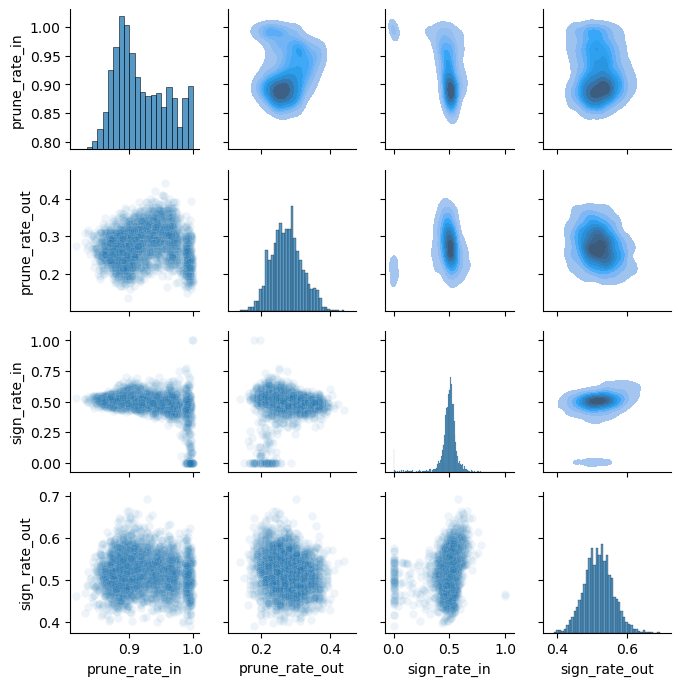

In [23]:
# save all the plots

for dataset in tqdm(["SVHN_IMP","CINIC_IMP","CIFAR_IMP","RSN"], leave=False, desc="model type"):
    
    #store_sign_distr_plots(wts_per_dataset, dataset)
    store_collective_sign_distr_plots(wts_per_dataset, dataset)


Observations:

- prune rate in has a larger low cluster and a smaller high cluster
- prune rate out is more varied
- sign rate in is very focused at 0.5 (a balanced sign ratio)
- sign rate out is more spread out with a bit more positive signs
- the more the ingoing connections are pruned, the more their signs are unbalanced.
- the same goes for outgoing connections, though they seem to be less strict with this


### Store 1 dimesnional sign distribution plots

In [44]:
def get_collective_sign_distr(name, n_wts):

    # collect all the sign distributions in one huge dataFrame
    coll_sign_distr = pd.DataFrame()
    for i in range(n_wts):
        sign_distr = pd.read_csv(f'2b Sign distributions/{name}_{i}_sign_distr.csv')
        coll_sign_distr = pd.concat([coll_sign_distr, sign_distr])

    return coll_sign_distr

In [45]:
def get_super_coll_sign_distr():
    super_coll_sign_distr = pd.DataFrame()
    for dataset in ["SVHN_IMP","CINIC_IMP","CIFAR_IMP","RSN"]:
        coll_sign_distr = get_collective_sign_distr(dataset, 15)
        coll_sign_distr["model"] = dataset
        super_coll_sign_distr = pd.concat([super_coll_sign_distr, coll_sign_distr])
    return super_coll_sign_distr

/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/net/projects/scratch/summer/valid_until_31_January_2025/epetersen/miniconda3/envs/thesis/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mo

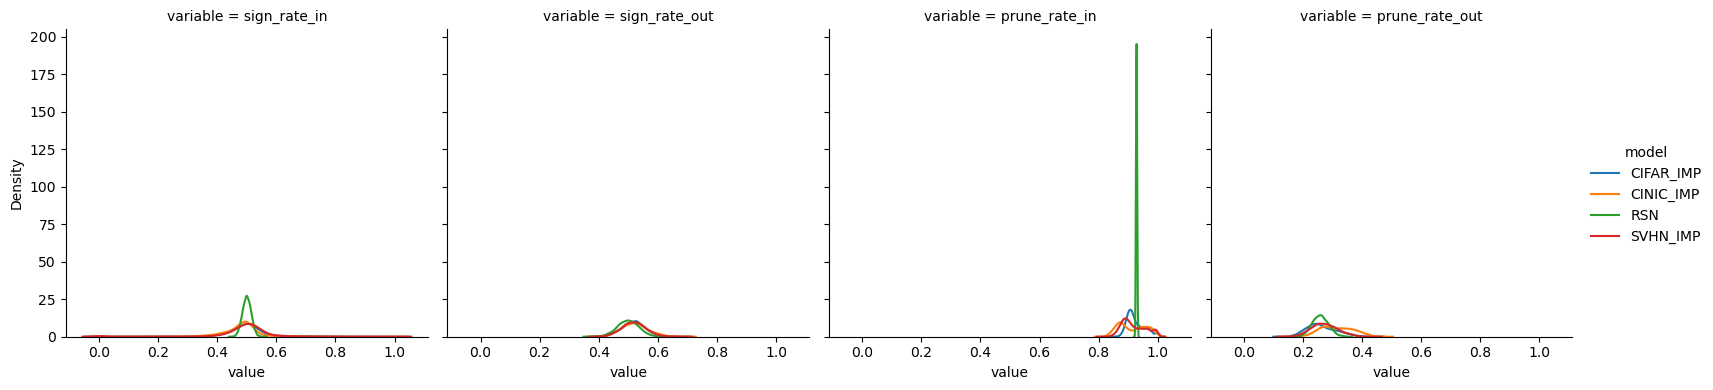

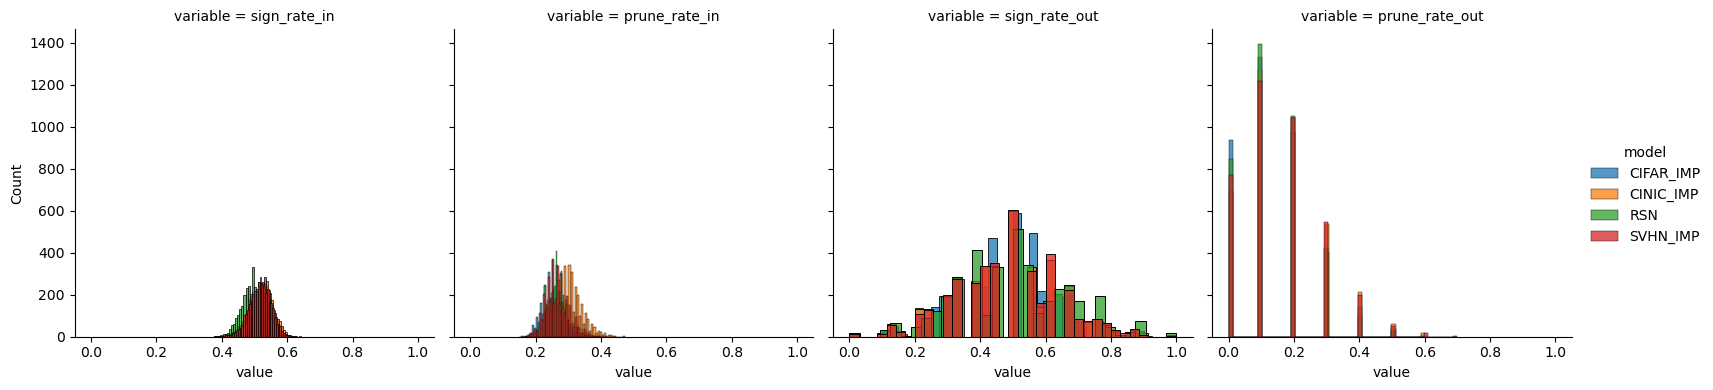

In [51]:

super_coll_sign_distr = get_super_coll_sign_distr()

# layer dense1

coll_sign_distr = super_coll_sign_distr[super_coll_sign_distr["layer"] == "dense1"][["prune_rate_in","prune_rate_out","sign_rate_in","sign_rate_out","model"]]
coll_sign_distr = coll_sign_distr.melt("model", var_name='variable', value_name='value').sort_values(['model']).reset_index(drop=True)

# plot the dataframe
g1 = sns.FacetGrid(coll_sign_distr, hue="model", col="variable", height=4)
g1.map(sns.kdeplot, "value")
g1.add_legend()

# layer dense2

coll_sign_distr = super_coll_sign_distr[super_coll_sign_distr["layer"] == "dense2"][["prune_rate_in","prune_rate_out","sign_rate_in","sign_rate_out","model"]]
coll_sign_distr = coll_sign_distr.melt("model", var_name='variable', value_name='value').sort_values(['model']).reset_index(drop=True)

# plot the dataframe
g2 = sns.FacetGrid(coll_sign_distr, hue="model", col="variable", height=4)
g2.map(sns.histplot, "value")
g2.add_legend()

## Unconnected Statistics

,no_incomming,no_outgoing,no_total_conncetions,layer,model
0,28,0,0,dense1,WT_SVHN_IMP_0
2,28,0,0,dense1,WT_SVHN_IMP_1
4,53,0,0,dense1,WT_SVHN_IMP_2
6,21,0,0,dense1,WT_SVHN_IMP_3
8,21,0,0,dense1,WT_SVHN_IMP_4
10,37,0,0,dense1,WT_SVHN_IMP_5
12,27,0,0,dense1,WT_SVHN_IMP_6
14,26,0,0,dense1,WT_SVHN_IMP_7
16,38,0,0,dense1,WT_SVHN_IMP_8
18,31,0,0,dense1,WT_SVHN_IMP_9


,no_incomming,no_outgoing,no_total_conncetions,layer,model
0,54,0,0,dense1,WT_CINIC_IMP_0
2,45,0,0,dense1,WT_CINIC_IMP_1
4,47,0,0,dense1,WT_CINIC_IMP_2
6,36,0,0,dense1,WT_CINIC_IMP_3
8,47,0,0,dense1,WT_CINIC_IMP_4
10,43,0,0,dense1,WT_CINIC_IMP_5
12,44,0,0,dense1,WT_CINIC_IMP_6
14,54,0,0,dense1,WT_CINIC_IMP_7
16,36,0,0,dense1,WT_CINIC_IMP_8
18,41,0,0,dense1,WT_CINIC_IMP_9


,no_incomming,no_outgoing,no_total_conncetions,layer,model
0,14,0,0,dense1,WT_CIFAR_IMP_0
2,14,0,0,dense1,WT_CIFAR_IMP_1
4,20,0,0,dense1,WT_CIFAR_IMP_2
6,18,0,0,dense1,WT_CIFAR_IMP_3
8,9,0,0,dense1,WT_CIFAR_IMP_4
10,3,0,0,dense1,WT_CIFAR_IMP_5
12,8,0,0,dense1,WT_CIFAR_IMP_6
14,10,0,0,dense1,WT_CIFAR_IMP_7
16,6,0,0,dense1,WT_CIFAR_IMP_8
18,6,0,0,dense1,WT_CIFAR_IMP_9


,no_incomming,no_outgoing,no_total_conncetions,layer,model
0,0,0,0,dense1,RSN_0
2,0,0,0,dense1,RSN_1
4,0,0,0,dense1,RSN_2
6,0,0,0,dense1,RSN_3
8,0,0,0,dense1,RSN_4
10,0,0,0,dense1,RSN_5
12,0,0,0,dense1,RSN_6
14,0,0,0,dense1,RSN_7
16,0,0,0,dense1,RSN_8
18,0,0,0,dense1,RSN_9


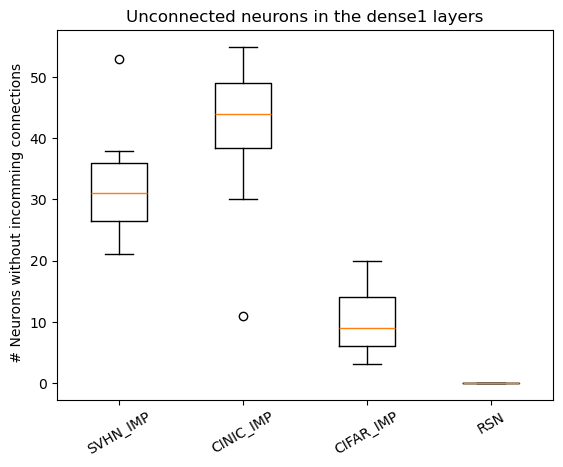

<Figure size 640x480 with 0 Axes>

In [3]:
connectivity_stats = []
connectivity_names = []

for dataset in ["SVHN_IMP","CINIC_IMP","CIFAR_IMP","RSN"]:
    unconnected_statistics = pd.read_csv(f'2b Sign distributions/{dataset}_unconnected_statistic.csv')
    display(unconnected_statistics[unconnected_statistics["layer"] == "dense1"])
    filtered_statistics = unconnected_statistics[unconnected_statistics["layer"] == "dense1"]
    filtered_statistics = filtered_statistics["no_incomming"]
    connectivity_stats.append(list(filtered_statistics))
    connectivity_names.append(dataset)


    
fig, ax = plt.subplots()
ax.set_ylabel(" # Neurons without incomming connections")
bplot = ax.boxplot(connectivity_stats)
plt.xticks(range(1,len(connectivity_names)+1), connectivity_names, rotation=30)
plt.title("Unconnected neurons in the dense1 layers")
plt.show()
plt.savefig(f"3b Plots/unconnected_neurons_IMP_dense1.png")